# DiploDatos 2021

### Categorización de publicaciones de productos realizadas en Mercado Libre

### 05 - Aprendizaje No Supervisado

#### Condiciones generales que aplican a todos los prácticos:

- Las notebooks tienen que ser 100% reproducibles, es decir al ejecutar las celdas tal cuál como se entrega la notebook se deben obtener los mismos resultados sin errores.
- Código legible, haciendo buen uso de las celdas de la notebook y en lo posible seguir estándares de código para *Python* (https://www.python.org/dev/peps/pep-0008/).
- Utilizar celdas tipo *Markdown* para ir guiando el análisis.
- Limpiar el output de las celdas antes de entregar el notebook (ir a `Kernel` --> `Restart Kernel and Clear All Ouputs`).
- Incluir conclusiones del análisis que se hizo en la sección "Conclusiones". Tratar de aportar valor en esta sección, ser creativo.

## 1. Consignas

El objetivo de este **TP** es aplicar técnicas de aprendizaje *no* supervisado.

#### Sección 1: Modelado

Implementar el algoritmo de aprendizaje no supervisado *K-means*:

- Para la implementación de este punto no es necesario la categoría del título.
- Utilizar los embeddings de los títulos.
- Entrenar el modelo de *K-means*.
- Para el entrenamiento tener en cuenta la siguiente sección.

#### Sección 2: Encontrar el número óptimo de clusters

Investigar e implementar alguno de los siguientes métodos para encontrar el número óptimo de clusters:

- *Silhouette Method*
- *Elbow Method* 

#### Sección 3: Análisis y Visualización

Responder las siguientes preguntas (puede ser por medio de una tabla o gráfico):

- ¿Cuál es el **Top 10** de las categorías más presentes en cada cluster?

- ¿De cada categoría, que  porcentaje de sus títulos pertenece a cada cluster?

Para responder estas preguntas es necesario hacer el mapeo entre el título y el cluster al cual pertenece.

## 2. Código y análisis

Instalaciones necesarias.

In [1]:
!pip install Unidecode

Importaciones necesarias.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

Lectura de dataset reducido.

In [3]:
df_dataset = pd.read_csv('DataSet/dataset.csv')

Estudiamos el dataset brevemente antes de comenzar a operar sobre el mismo.

In [4]:
df_dataset.describe()

,title,label_quality,language,category
count,646760,646760,646760,646760
unique,646019,2,2,20
top,Teclado Casio Ctk 601,unreliable,portuguese,PANTS
freq,2,551878,328992,35973


In [5]:
classes = np.sort(df_dataset.category.unique())

print(f'Dimensiones: {df_dataset.shape}')
print('----------')
print(f'Variables: {list(df_dataset.columns)}')
print('----------')
print(f'Categorías: {list(classes)}')

Dimensiones: (646760, 4)
----------
Variables: ['title', 'label_quality', 'language', 'category']
----------
Categorías: ['BABY_CAR_SEATS', 'BABY_STROLLERS', 'COFFEE_MAKERS', 'ELECTRIC_DRILLS', 'HAIR_CLIPPERS', 'KITCHEN_SINKS', 'MATTRESSES', 'MEMORY_CARDS', 'MOTORCYCLE_JACKETS', 'MUSICAL_KEYBOARDS', 'PANTS', 'PUREBRED_DOGS', 'RANGES', 'REFRIGERATORS', 'ROLLER_SKATES', 'SEWING_MACHINES', 'SHORTS', 'SUITCASES', 'WALL_CLOCKS', 'WINES']


**Sección 0**
Preparando el conjunto de datos.

In [6]:
from scripts.utils import cleaning

df_dataset['clean_title'] = df_dataset.title.apply(cleaning)

df_dataset.head()

,title,label_quality,language,category,clean_title
0,Galoneira Semi Industrial,unreliable,portuguese,SEWING_MACHINES,galoneira semi industrial
1,Máquina De Coser Brother Industrial,unreliable,spanish,SEWING_MACHINES,maquina de coser brother industrial
2,Teclado Casio Wk-240 76 Teclas Profissional St...,unreliable,portuguese,MUSICAL_KEYBOARDS,teclado casio wk teclas profissional standard
3,Heladera Gafa 380 Impecable Urgente,unreliable,spanish,REFRIGERATORS,heladera gafa impecable urgente
4,Butaca 6 Cuotas Sin Interes!! Para Auto Bebes...,unreliable,spanish,BABY_CAR_SEATS,butaca cuotas sin interes para auto bebesit ...


In [7]:
# Convertimos los títulos curados en listas de palabras.
X = df_dataset.clean_title.apply(lambda ct: ct.split()).values

**Sección 1**
Modelado.

Utilizaremos el [tutorial](https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/) de Dylan Castillo para el desarrollo del laboratorio.

Se entrena un modelo de **Word2Vec** utilizando los títulos curados.

In [8]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=X, size=50, seed=123)

Revisamos los resultados de *similaridad* de algunas palabras arbitrarias.

In [9]:
model.wv.most_similar('teclado')

[('tecl', 0.7662758827209473),
 ('teclados', 0.7640673518180847),
 ('ritmos', 0.7606066465377808),
 ('sample', 0.7311817407608032),
 ('oitavas', 0.7219606637954712),
 ('expertkeys', 0.7172209024429321),
 ('sinte', 0.71109539270401),
 ('timbres', 0.7081478238105774),
 ('piano', 0.7068670988082886),
 ('parateclado', 0.7066861391067505)]

In [10]:
model.wv.most_similar('maquina')

[('maq', 0.786653459072113),
 ('maquinas', 0.7347556352615356),
 ('mquina', 0.6953234672546387),
 ('arremate', 0.6219831705093384),
 ('tesoura', 0.6127080917358398),
 ('maqyina', 0.6036962866783142),
 ('computarizado', 0.5783994197845459),
 ('calcador', 0.5651794075965881),
 ('makina', 0.562229335308075),
 ('pic', 0.5585757493972778)]

In [11]:
model.wv.most_similar('heladera')

[('heladeras', 0.7966678738594055),
 ('heldera', 0.7692970037460327),
 ('heladerafreezer', 0.7561392188072205),
 ('confreezer', 0.7492932677268982),
 ('ciclica', 0.742434561252594),
 ('puertas', 0.7352095246315002),
 ('freezer', 0.7263229489326477),
 ('frezzer', 0.6879883408546448),
 ('congelador', 0.6824544668197632),
 ('plateada', 0.6807135939598083)]

Se observan las primeras **10** palabras más similares a `teclado`, `maquina`, y `heladera`, en nuestro conjunto de datos.
Los resultados son totalmente razonables. Encontramos la palabra base en plural (*maquinas*), con errores de ortografía (*mquina*), abreviaturas (*maq*), e incluso su traducción en otros idiomas (*maquininha*). Aparte de esto se distingen palabras similares que comúnmente las acompañan (*freezer* en `heladera`, o *ritmos* en `teclado`).

Quizás esto también implica que la curación de nuestro conjunto de datos no es buena. Deberíamos encontrar palabras similares que suelen acompañar a la palabra base, y no derivados de esta que no nos aportan ninguna intuición sobre los datos.

Obtenemos los *embeddings* de nuestros títulos de publicaciones curados.

In [12]:
def vectorize(titles, model):
  """
  Generate vectors for list of titles using a Word Embedding.

  Args:
    titles: List of Publication Titles.
    model: Gensim's W2V Word Embedding.

  Returns:
    List of Publication Titles Vectors.
  """
  features = []
  zero_vector = np.zeros(model.vector_size)
  # Recorremos la totalidad de títulos.
  for title in titles:
    vectors = []
    # Recorremos la totalidad del título.
    for token in title:
      if token in model.wv:
        # Agregamos el vector de la palabra a los vectores.
        vectors.append(model.wv[token])
    if vectors:
      # Calculamos el promedio de los vectores.
      vectors = np.asarray(vectors)
      avg_vec = vectors.mean(axis=0)
      features.append(avg_vec)
    else:
      features.append(zero_vector)
  return features

In [13]:
vectorized_titles = vectorize(X, model)

print(f'#Títulos Vectorizados: {len(vectorized_titles)}')

i = 0
print(f'Título Curado:\n{X[i]}')
print(f'Título Vectorizado:\n{vectorized_titles[i]}')

#Títulos Vectorizados: 646760
Título Curado:
['galoneira', 'semi', 'industrial']
Título Vectorizado:
[ 0.3059006  -0.99268866 -1.0143918  -0.03996772 -1.2773666  -0.41785678
  0.04299648 -0.24498916 -1.4337763   0.81968695  2.1441543  -0.7108107
  1.6793538  -3.2701066  -1.9016962   1.9874297  -0.5584544  -1.2525789
  1.0194362   0.27745262  1.6809279   1.4362494   0.17357166  1.6306762
 -0.38786614  0.27145413  0.34020242  0.80034167  3.4322398  -1.1172633
  0.97126365 -0.27022532  1.7522289  -1.7605337   0.0200094  -1.6663834
 -0.22437064 -0.44523466 -1.1367579   1.1661216   0.90830594  2.790827
 -1.9152064  -0.9414945  -0.23970802  0.44912305 -1.4020821   0.6467108
 -0.68718624 -0.3814915 ]


**Sección 2**
*Elbow Method*

Intentamos encontrar el número óptimo de clusters.

#Clusters: 1 ---> Inertia: 35050845.27228944
#Clusters: 2 ---> Inertia: 31880090.667693984
#Clusters: 3 ---> Inertia: 29999308.503660947
#Clusters: 4 ---> Inertia: 28494843.40656859
#Clusters: 5 ---> Inertia: 26921722.87121429
#Clusters: 6 ---> Inertia: 25719800.431680933
#Clusters: 7 ---> Inertia: 24473231.970289316
#Clusters: 8 ---> Inertia: 23126778.703331992
#Clusters: 9 ---> Inertia: 22119188.788476672
#Clusters: 10 ---> Inertia: 20954735.08607701
#Clusters: 11 ---> Inertia: 20462145.751365878
#Clusters: 12 ---> Inertia: 19908859.559971448
#Clusters: 13 ---> Inertia: 18975583.34044599
#Clusters: 14 ---> Inertia: 18159391.49966747
#Clusters: 15 ---> Inertia: 17701212.51188306
#Clusters: 16 ---> Inertia: 17058092.596975155
#Clusters: 17 ---> Inertia: 16634728.960781518
#Clusters: 18 ---> Inertia: 16087271.389127063
#Clusters: 19 ---> Inertia: 15499277.207310334
#Clusters: 20 ---> Inertia: 15083310.950758912


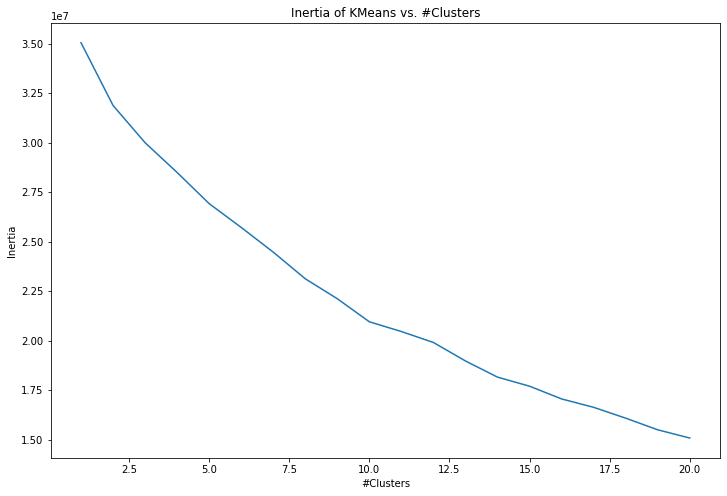

In [14]:
inf_bound = 1
sup_bound = 20

scores = []
# Prueba para elegir el hiperparámetro 'n_clusters'.
for i in range(inf_bound, sup_bound + 1):
  kMeans = KMeans(n_clusters=i, random_state=123)
  inertia = kMeans.fit(vectorized_titles).inertia_
  scores.append(inertia)
  print(f'#Clusters: {i} ---> Inertia: {inertia}')

plt.figure(figsize=(12, 8))
plt.plot(np.arange(inf_bound, sup_bound + 1), scores)
plt.xlabel('#Clusters')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans vs. #Clusters');

In [15]:
best_NCluster = 10

**Observación**

En esta instancia aplicamos el *método del codo* sobre la **inercia** para tener una estimación de cual podría ser la cantidad de clusters óptima para nuestro problema.

Se utiliza *1* como límite inferior, ya que es un valor trivial para realizar el agrupamiento, y *20* como límite superior, ya que es la cantidad de clases que existen en nuestro conjunto de datos.

Al estudiar la gráfica no encontramos ningún *codo* pronunciado, por lo que no es posible definir una cantidad óptima de clusters con demasiada seguridad.
Debido a esto, elegiremos **10** de manera arbitraria por ser un valor intermedio con respecto a la cantidad de categorías de productos en nuestro conjunto de datos.

La **inercia** se la entiende como la suma de las distancias cuadradas de cada muestra al centro (calculado por **KMeans**) más cercano.

In [16]:
def KMeans_clusters(X, k, printSilhouette):
  """
  Generate clusters and print Silhouette metrics using KMeans.

  Args:
    X: List of vectors.
    k: Number of clusters.
    printSilhouette: Print silhouette values per cluster.

  Returns:
    Trained clustering model and labels based on X.
  """
  km = KMeans(n_clusters=k, random_state=123).fit(X)
  print(f'For n_clusters = {k}')
  print(f'Inertia: {km.inertia_}')
  print(f'Silhouette Coefficient: {silhouette_score(X, km.labels_):0.2f}')
  if printSilhouette:
    sample_silhouette_values = silhouette_samples(X, km.labels_)
    print(f'Silhouette Values...')
    silhouette_values = []
    for i in range(k):
      cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
      silhouette_values.append(
          (
           i,
           cluster_silhouette_values.shape[0],
           cluster_silhouette_values.mean(),
           cluster_silhouette_values.min(),
           cluster_silhouette_values.max(),
           )
          )
    silhouette_values = sorted(
        silhouette_values, key=lambda tup: tup[2], reverse=True
        )
    for s in silhouette_values:
      print(f'>Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}')
  return km, km.labels_

In [17]:
clustering, cluster_labels = KMeans_clusters(vectorized_titles, best_NCluster, True)

For n_clusters = 10
Inertia: 20954735.08607701
Silhouette Coefficient: 0.19
Silhouette Values...
>Cluster 2: Size:30075 | Avg:0.54 | Min:0.04 | Max: 0.66
>Cluster 8: Size:30359 | Avg:0.35 | Min:-0.08 | Max: 0.50
>Cluster 5: Size:32157 | Avg:0.31 | Min:-0.01 | Max: 0.44
>Cluster 6: Size:63613 | Avg:0.23 | Min:-0.07 | Max: 0.38
>Cluster 4: Size:87082 | Avg:0.16 | Min:-0.17 | Max: 0.31
>Cluster 3: Size:96335 | Avg:0.16 | Min:-0.17 | Max: 0.29
>Cluster 9: Size:76070 | Avg:0.16 | Min:-0.16 | Max: 0.31
>Cluster 1: Size:58778 | Avg:0.15 | Min:-0.15 | Max: 0.30
>Cluster 0: Size:65787 | Avg:0.14 | Min:-0.14 | Max: 0.30
>Cluster 7: Size:106504 | Avg:0.12 | Min:-0.20 | Max: 0.27


Al analizar el coeficiente de *silueta* para cada cluster observamos que el agrupamiento **2** obtiene el mejor promedio (además de ser el más pequeño), y que el agrupamiento **7** obtiene el peor promedio (además de ser el más grande).
Quizás ambas condiciones estén correlacionadas.

In [18]:
df_dataset['clusters'] = cluster_labels

df_dataset.head()

,title,label_quality,language,category,clean_title,clusters
0,Galoneira Semi Industrial,unreliable,portuguese,SEWING_MACHINES,galoneira semi industrial,3
1,Máquina De Coser Brother Industrial,unreliable,spanish,SEWING_MACHINES,maquina de coser brother industrial,3
2,Teclado Casio Wk-240 76 Teclas Profissional St...,unreliable,portuguese,MUSICAL_KEYBOARDS,teclado casio wk teclas profissional standard,8
3,Heladera Gafa 380 Impecable Urgente,unreliable,spanish,REFRIGERATORS,heladera gafa impecable urgente,0
4,Butaca 6 Cuotas Sin Interes!! Para Auto Bebes...,unreliable,spanish,BABY_CAR_SEATS,butaca cuotas sin interes para auto bebesit ...,6


In [19]:
print('Términos más representativos por c/cluster (en base a centros)...')

for i in range(best_NCluster):
  tokens_per_cluster = []
  most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
  for t in most_representative:
    tokens_per_cluster.append(t[0])
  print(f'Cluster {i}: {" | ".join(tokens_per_cluster)}')

Términos más representativos por c/cluster (en base a centros)...
Cluster 0: mgas | cocinar | peltre | argsale | contapa
Cluster 1: torneiras | ewt | esterilizador | bico | prateleiras
Cluster 2: kodak | uhs | uhsi | android | sdhc
Cluster 3: velocidades | whall | monofasica | fsb | qirui
Cluster 4: caqui | ciganinha | colete | puidos | gg
Cluster 5: visco | latex | bamboo | viscoelastico | europillow
Cluster 6: cadeirao | parasol | carrier | akg | conbase
Cluster 7: sagrada | superieur | barton | murrieta | burro
Cluster 8: oitavas | ritmos | teclado | midi | expertkeys
Cluster 9: fucsia | naranja | corazones | unisex | medium


Si analizamos las palabras más representativas de cada cluster, obtenemos algunos resultados curiosos.
Los clusters con mejor coeficiente de *silueta* promedio son **2**, **8**, y **5**.

- En el cluster **2** destacan palabras que parecen pertenecer a `MEMORY_CARDS`.
- En el cluster **8** destacan palabras que parecen pertenecer a `MUSICAL_KEYBOARDS`.
- En el cluster **5** destacan palabras que parecen pertenecer a `MATTRESSES`.

In [20]:
random_Cluster = 3

In [21]:
most_representative_titles = np.argsort(
    np.linalg.norm(vectorized_titles - clustering.cluster_centers_[random_Cluster], axis=1)
    )

for t in most_representative_titles[:5]:
    print(df_dataset.clean_title.values[t])
    print('----------')

 motores maquina costura ns v hz a rpm w 
----------
maquina de corte  polegadas  watts   vts
----------
bobina motor braco de mover lamina maquina clip v w
----------
maquina de corte faca  pol copia servicemac
----------
motor maquina de costura fm  v  hz a w
----------


Seleccionamos un cluster cualquiera, en este caso **3**, y analizamos los títulos de publicaciones más representativos para el agrupamiento.
Recordar que el coeficiente de *silueta* promedio para el conjunto no fue bueno, por lo que los resultados pueden no ser demasiado coherentes.

Al inspeccionar los títulos resulta evidente que estamos frente al cluster de las máquinas, todos los títulos encontrados hacen referencia a alguna de las siguientes categorías `SEWING_MACHINES`, `HAIR_CLIPPERS`, o `ELECTRIC_DRILLS`.

**Sección 3**
Visualización.

Utilizaremos `crosstab` para responder a las preguntas planteadas.

In [22]:
# Cantidad de categorías por cada cluster.
pd.crosstab(index=df_dataset['category'], columns=df_dataset['clusters'], margins=True)

clusters,0,1,2,3,4,5,6,7,8,9,All
category,,,,,,,,,,,
BABY_CAR_SEATS,7,12,2,26,198,1,33298,480,0,139,34163
BABY_STROLLERS,6,5,9,27,368,3,30092,507,1,335,31353
COFFEE_MAKERS,14997,14760,0,3557,30,0,11,1665,2,82,35104
ELECTRIC_DRILLS,56,93,1,30203,14,0,1,395,0,57,30820
HAIR_CLIPPERS,74,64,0,31278,90,0,9,815,1,41,32372
KITCHEN_SINKS,15646,14249,0,80,49,4,5,592,0,10,30635
MATTRESSES,4,4,0,6,83,32094,49,624,0,103,32967
MEMORY_CARDS,4,20,29983,201,65,0,8,1187,53,43,31564
MOTORCYCLE_JACKETS,2,0,0,65,16991,0,1,215,46,15295,32615


Resumiendo la tabla obtenida, podemos limitarnos al *podio* de categorías por cada cluster...

| Podio  |  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 1º  | `REFRIGERATORS` | `RANGES`        | `MEMORY_CARDS` | `HAIR_CLIPPERS`   | `PANTS`              | `MATTRESSES` | `BABY_CAR_SEATS` | `PUREBRED_DOGS` | `MUSICAL_KEYBOARDS` | `PANTS`              |
| 2º  | `RANGES`        | `COFFEE_MAKERS` | -------------- | `ELECTRIC_DRILLS` | `ROLLER_SKATES`      | ------------ | `BABY_STROLLERS` | `WINES`         | ------------------- | `MOTORCYCLE_JACKETS` |
| 3º  | `KITCHEN_SINKS` | `KITCHEN_SINKS` | -------------- | `SEWING_MACHINES` | `SUITCASES`          | ------------ | ---------------- | `WALL_CLOCKS`   | ------------------- | `SHORTS`             |
| 4º  | `COFFEE_MAKERS` | `REFRIGERATORS` | -------------- | ----------------- | `MOTORCYCLE_JACKETS` | ------------ | ---------------- | --------------- | ------------------- | `SUITCASES`          |
| 5º  | --------------- | --------------- | -------------- | ----------------- | `SHORTS`             | ------------ | ---------------- | --------------- | ------------------- | `ROLLER_SKATES`      |

Como solo nos queremos quedar con los resultados generales, vamos a ignorar las categorías con pocos representantes en cada cluster.
De esta forma, solo listaremos en la tabla las clases más numerosas para cada agrupamiento.

In [23]:
# Porcentajes de categorías por cada cluster.
pd.crosstab(index=df_dataset['category'], columns=df_dataset['clusters'], normalize='index', margins=True)

clusters,0,1,2,3,4,5,6,7,8,9
category,,,,,,,,,,
BABY_CAR_SEATS,0.000205,0.000351,0.000059,0.000761,0.005796,0.000029,0.974680,0.014050,0.000000,0.004069
BABY_STROLLERS,0.000191,0.000159,0.000287,0.000861,0.011737,0.000096,0.959781,0.016171,0.000032,0.010685
COFFEE_MAKERS,0.427216,0.420465,0.000000,0.101327,0.000855,0.000000,0.000313,0.047430,0.000057,0.002336
ELECTRIC_DRILLS,0.001817,0.003018,0.000032,0.979981,0.000454,0.000000,0.000032,0.012816,0.000000,0.001849
HAIR_CLIPPERS,0.002286,0.001977,0.000000,0.966205,0.002780,0.000000,0.000278,0.025176,0.000031,0.001267
KITCHEN_SINKS,0.510723,0.465122,0.000000,0.002611,0.001599,0.000131,0.000163,0.019324,0.000000,0.000326
MATTRESSES,0.000121,0.000121,0.000000,0.000182,0.002518,0.973519,0.001486,0.018928,0.000000,0.003124
MEMORY_CARDS,0.000127,0.000634,0.949911,0.006368,0.002059,0.000000,0.000253,0.037606,0.001679,0.001362
MOTORCYCLE_JACKETS,0.000061,0.000000,0.000000,0.001993,0.520957,0.000000,0.000031,0.006592,0.001410,0.468956


En la tabla de porcentajes se reflejan resultados similares a los obtenidos en la tabla de cantidades.
De todas formas intentaremos extraer algo de información.

Se podrían separar a los agrupamientos encontrados en categorías; los agrupamientos **generales** y los agrupamientos **específicos**.

- Un agrupamiento **general** es aquel que suele abarcar varias categorías, pero no tiende a ser completo (solo alcanza a tomar entre el 0.4 y el 0.5 de una clase). Comparten sus clases con otros clusters. Ejemplos de estos serían **0**, **1**, **4**, y **9**.

- Un agrupamiento **específico** es aquel que suele comprender una única categoría casi en su totalidad (suelen superar el 0.9 de la clase). Cuando abarcan más de una clase no lo hacen de manera necesariamente coherente. Ejemplos de estos serían **2**, **3**, **5**, **6**, **7**, y **8**.

## 3. Conclusiones

A lo largo del laboratorio se han realizado observaciones sobre los resultados obtenidos.
Por lo que en esta parte del reporte no hay demasiado para adicionar al trabajo hecho.
Quizás es importante notar que sería beneficioso, para nuestra comprensión del conjunto de datos, repetir el estudio planteado con una cantidad de agrupamientos diferente.
Probablemente se consigan clusters totalmente diferentes, donde algunas podrían ser más coherentes a los hallados en el notebook.